## Data Scrapping from Twitter

In [89]:
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
stop = stopwords.words("english")
import configparser

config = configparser.ConfigParser()
config_path =  config.ini
config.read(config_path)


In [90]:
consumer_key = config['consumer_key']
consumer_secret = config['consumer_secret']
access_token = config['access_token']
access_secret = config['access_secret']
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [91]:
def get_users(twitterNewsChannels):
    
    usersFromTweets = pd.DataFrame(columns = ["ActiveNewsReaders","Popularity", "Verified","totalTweets"])
    numberOfUsersMined = 0
    
    for newsChannel in twitterNewsChannels:
        for tweet in api.user_timeline(screen_name = newsChannel, count=10):
            for reTweet in api.retweets(tweet.id):
                
                usersFromTweets.loc[numberOfUsersMined, "ActiveNewsReaders"] = reTweet.user.screen_name
                
                if(reTweet.user.friends_count == 0):
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count
                else:
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count/reTweet.user.friends_count
                
                usersFromTweets.loc[numberOfUsersMined, "Verified"] = reTweet.user.verified
                usersFromTweets.loc[numberOfUsersMined, "totalTweets"] = reTweet.user.statuses_count
                
                numberOfUsersMined = numberOfUsersMined + 1
    
    return usersFromTweets

In [92]:
NewsChannelsUsernames = ["nytimes","business","washingtonpost"]
usersData = get_users(NewsChannelsUsernames)

In [93]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets
0,asil09,0.966512,False,40368
1,MobiusAileZero,0.313187,False,787
2,Jeanetteorosco1,0.567568,False,16037
3,towandaism,0.290833,False,25746
4,TigerLili24,0.39075,False,61990


In [94]:
usersData.shape

(425, 4)

In [95]:
usersData.drop_duplicates(inplace = True)
usersData.shape

(336, 4)

In [96]:
usersData.Popularity.max()

1314.0

In [97]:
usersData = usersData[(usersData.totalTweets > 10) & (usersData.Popularity > 1)]
usersData.shape

(100, 4)

In [98]:
usersData = usersData.reset_index(drop=True)

In [99]:
def getTweets(user):
    twitterUser = api.get_user(user)
    
    tweets = api.user_timeline(screen_name = user, count = 10,tweet_mode='extended')
    tentweets = []
    for tweet in tweets:
        if tweet.full_text.startswith("RT @") == True:
            tentweets.append(tweet.retweeted_status.full_text)
        else:
            tentweets.append(tweet.full_text)
       
    return tentweets

In [100]:
usersData["tweets"] = None

for i in range(len(usersData)):
    usersData.loc[i, "tweets"] = getTweets(usersData.ActiveNewsReaders[i])

In [101]:
usersData.head(10)

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets
0,CaddenKathleen,1.12739,False,9300,[Who's safe and who's in danger heading into e...
1,JanieceStaton,1.26016,False,436232,[Elections are how our voices are heard.\n\nTh...
2,Libby_italiana,1.23611,False,53118,[Yeah all of this is factually and legally wro...
3,SWS_EDU,1.54535,False,433901,[He was desperate to stay in the U.S. Then Pre...
4,ReneeVoiceBrand,3.42506,False,315728,"[Yes, how could we forget when Democrats atten..."
5,BillEsteem,1.00148,False,4561,[Josh Donaldson with a LOUD home run to left 🔊...
6,ClauFernandez1,6.57143,False,14819,[¡Manos privilegiadas! 👐 ¡Qué espectáculo de @...
7,PradoPecci,5.36923,False,648634,[@BigRicardo23 Foi de longe o melhor que vi. G...
8,deduped_nytimes,237.5,False,114008,[He was desperate to stay in the U.S. Then Pre...
9,james_khonkaen,2.68605,False,79441,[Rachel Roddy’s potato and mushroom bake recip...


In [102]:
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Sohil\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [103]:
def processTweets(tweets):
    
    #cleaning of tweets
    cleanedTweets = []
    for tweet in tweets:
        tw = re.sub('http\S+', '', tweet) #remove links
        tw = re.sub('RT', '', tw) #remove RT of retweet
        tw = re.sub('@[^\s]+','',tw) #remove usernames 
        tw = "".join([char for char in tw if char not in string.punctuation]) #remove punctuations
        tw = tw.lower() #converting to lowercase letters
        tw = ' '.join([word for word in tw.split() if word not in (stop)]) #removing stop words
        tw = ' '.join([word for word in tw.split() if len(word)>1])
        cleanedTweets.append(tw)

    cleanedTweets = ' '.join(cleanedTweets) #joining all tweets
    
    #tokenization
    ProcessedTweets = word_tokenize(cleanedTweets)
    
    ProcessedTweets = [word for word in ProcessedTweets if len(word)>1]
    
    #stemming
    ProcessedTweets = [ps.stem(word) for word in ProcessedTweets]
    
    #lammitization
    ProcessedTweets = [wn.lemmatize(word) for word in ProcessedTweets]
    
    ProcessedTweets = ' '.join(w for w in ProcessedTweets if w in words)
    return ProcessedTweets
        

<>:6: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-103-c90dae0869c4>:6: DeprecationWarning: invalid escape sequence \S
  tw = re.sub('http\S+', '', tweet) #remove links
<ipython-input-103-c90dae0869c4>:8: DeprecationWarning: invalid escape sequence \s
  tw = re.sub('@[^\s]+','',tw) #remove usernames


In [104]:
for i in range(len(usersData)):
    usersData.loc[i, "tweets"] = processTweets(usersData.tweets[i])

In [105]:
usersData.head(10)

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets
0,CaddenKathleen,1.12739,False,9300,who safe who danger head two game throne final...
1,JanieceStaton,1.26016,False,436232,elect may local elect school board water distr...
2,Libby_italiana,1.23611,False,53118,yeah factual legal wrong wonder get show video...
3,SWS_EDU,1.54535,False,433901,stay u trump made thousand asylum seeker depor...
4,ReneeVoiceBrand,3.42506,False,315728,ye could forget democrat attend trump tower me...
5,BillEsteem,1.00148,False,4561,josh loud home run left zoo director say attac...
6,ClauFernandez1,6.57143,False,14819,de royal fan think hold royal offend queen bir...
7,PradoPecci,5.36923,False,648634,de long genial joy come learn wit special coun...
8,deduped_nytimes,237.5,False,114008,stay u trump made thousand asylum seeker depor...
9,james_khonkaen,2.68605,False,79441,potato mushroom bake kitchen fan grail win for...


In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1,
                                 use_idf=True)

In [107]:

tfidf_matrix = tfidf_vectorizer.fit_transform(usersData.tweets)

In [108]:
tfidf_matrix

<100x132 sparse matrix of type '<class 'numpy.float64'>'
	with 2096 stored elements in Compressed Sparse Row format>

In [109]:
terms = tfidf_vectorizer.get_feature_names()

In [110]:
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.13421515, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15833582,
        0.11793124],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14138246, 0.14138246, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17904466, 0.        ,
        0.14065926]])

In [111]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [112]:
dist

array([[ 0.00000000e+00,  8.04466345e-01,  7.87689759e-01, ...,
         9.54331156e-01,  9.02885236e-01,  9.69760113e-01],
       [ 8.04466345e-01,  0.00000000e+00,  6.95374886e-01, ...,
         9.43528687e-01,  8.01669206e-01,  8.33489438e-01],
       [ 7.87689759e-01,  6.95374886e-01, -4.44089210e-16, ...,
         9.43061917e-01,  7.69943815e-01,  8.90571230e-01],
       ...,
       [ 9.54331156e-01,  9.43528687e-01,  9.43061917e-01, ...,
         0.00000000e+00,  8.97605045e-01,  9.79596018e-01],
       [ 9.02885236e-01,  8.01669206e-01,  7.69943815e-01, ...,
         8.97605045e-01,  0.00000000e+00,  8.77035211e-01],
       [ 9.69760113e-01,  8.33489438e-01,  8.90571230e-01, ...,
         9.79596018e-01,  8.77035211e-01, -2.22044605e-16]])

In [113]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index = usersData.ActiveNewsReaders)

,also,around,arrest,ask,attack,back,biggest,bill,black,bomb,...,way,whether,win,woman,work,world,would,write,wrong,year
ActiveNewsReaders,,,,,,,,,,,,,,,,,,,,,
CaddenKathleen,0.000000,0.000000,0.000000,0.249352,0.000000,0.249352,0.000000,0.000000,0.000000,0.215380,...,0.000000,0.000000,0.000000,0.000000,0.207758,0.000000,0.211482,0.000000,0.000000,0.000000
JanieceStaton,0.000000,0.000000,0.134215,0.000000,0.000000,0.000000,0.141566,0.137737,0.000000,0.000000,...,0.000000,0.000000,0.115260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Libby_italiana,0.000000,0.000000,0.000000,0.000000,0.000000,0.146467,0.000000,0.000000,0.000000,0.000000,...,0.136912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158336,0.117931
SWS_EDU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.124917,0.000000,0.117619,0.136963,0.000000,0.000000,0.226679,0.000000,0.000000,0.000000
ReneeVoiceBrand,0.000000,0.000000,0.000000,0.161868,0.000000,0.161868,0.000000,0.000000,0.000000,0.139815,...,0.000000,0.000000,0.142468,0.000000,0.134867,0.378437,0.000000,0.000000,0.000000,0.000000
BillEsteem,0.000000,0.000000,0.269202,0.000000,0.218847,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.204695,0.000000,0.000000,0.000000,0.000000
ClauFernandez1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166412
PradoPecci,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.198584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
deduped_nytimes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173454,0.000000,0.000000,0.277183,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136083,0.328894,0.000000,0.000000


In [114]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [115]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 run
 know
 trump
 would
 need
 say
 new
 point
 go
 think
Cluster 1:
 de
 la
 en
 lo
 el
 con
 se
 sri
 easter
 via
Cluster 2:
 trump
 make
 report
 elect
 day
 one
 say
 win
 easter
 man
Cluster 3:
 trump
 want
 right
 one
 must
 work
 support
 report
 like
 campaign
Cluster 4:
 sri
 church
 attack
 bomb
 faith
 easter
 mani
 hotel
 minor
 kill


In [116]:
titles = usersData.ActiveNewsReaders

In [117]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

In [118]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

C:\Users\Sohil\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\Sohil\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Sohil\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Sohil\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. 

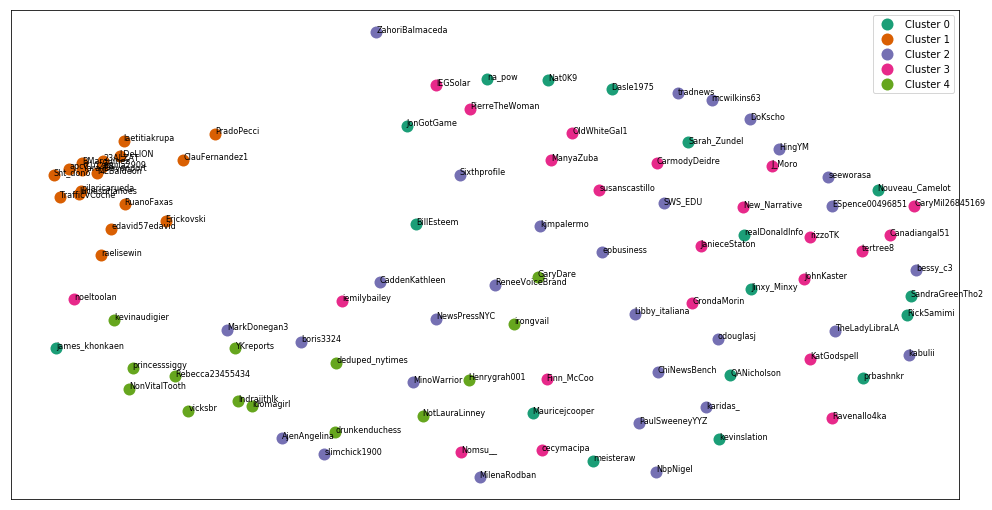

In [119]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show()
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Ward Clustering

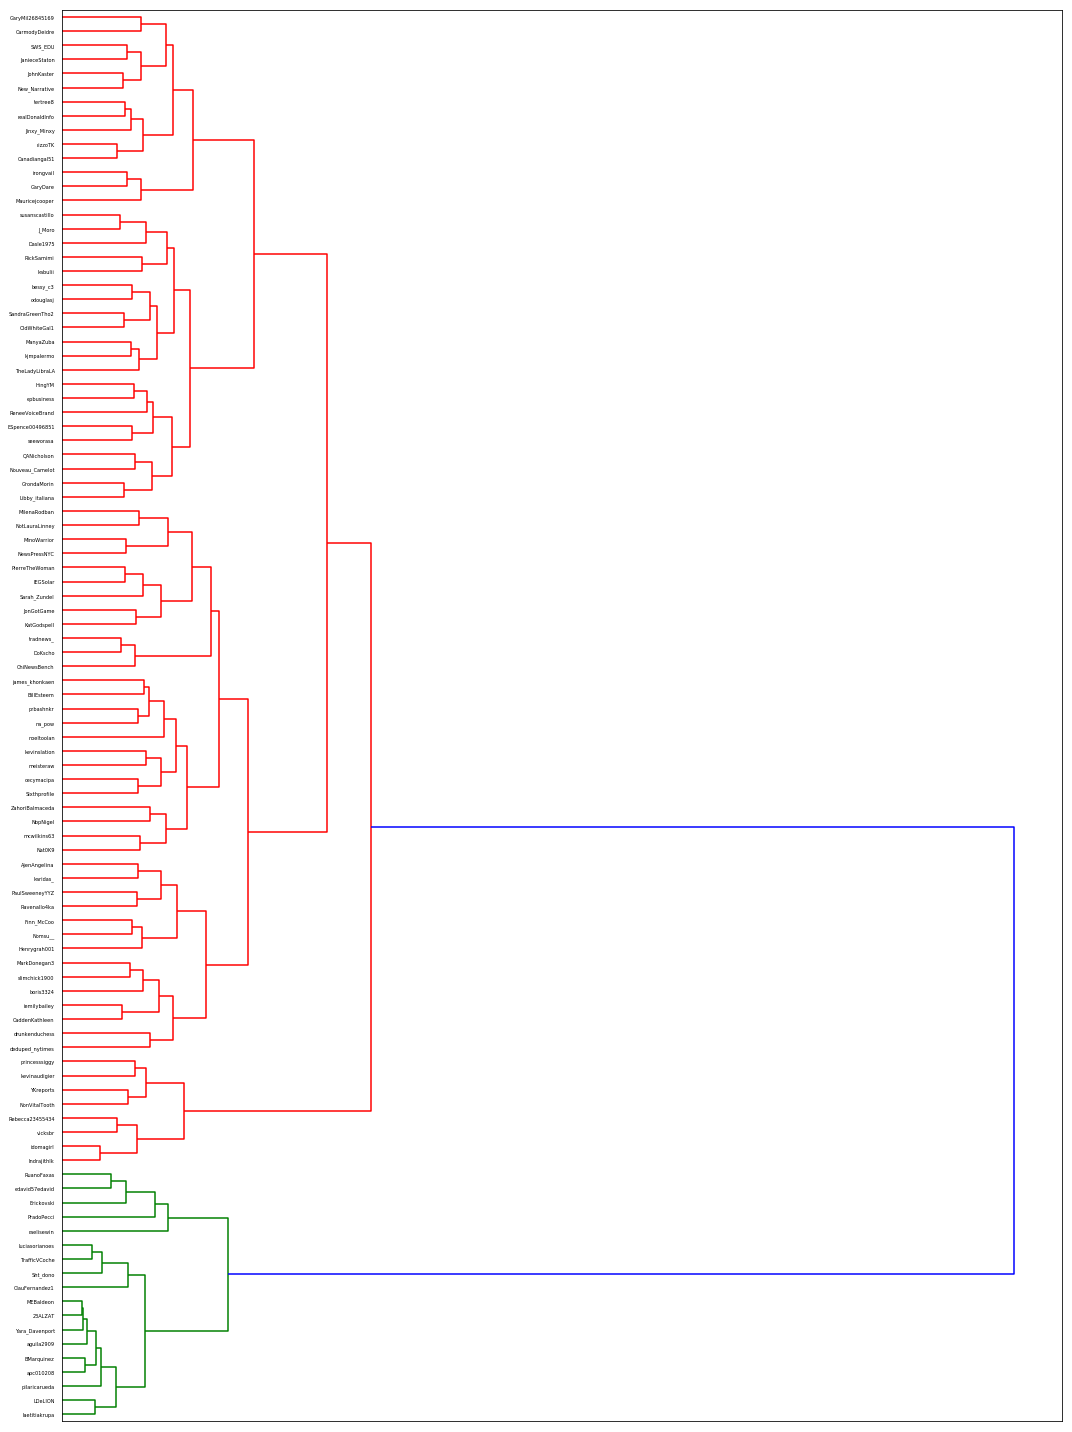

In [120]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles.values);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [121]:
#creating dataframe for tweets based on clustering results
usersData['cluster']=df.label


In [250]:
# Import required packages
import logging
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

In [251]:
# I am cleaning it from scratch as I built this earlier and am using N-grams
from numpy import array
from nltk.corpus import stopwords 
from gensim.corpora.dictionary import Dictionary
import string
# Convert to array
docs =array(usersData['tweets'])
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    #Remove stopwords
    docs = [[token for token in doc if token not in stop] for doc in docs]
    
    #Remove punctuation
    docs = [[token for token in doc if token not in exclude] for doc in docs]

    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 80
Number of documents: 100
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [260]:
usersData['corpus']=corpus
usersData['docs']=docs
#create unique list of names
UniqueNames = usersData['cluster'].unique()

#create a data frame dictionary to store data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
docscluster={elem : pd.DataFrame for elem in UniqueNames}
corpuscluster={elem : pd.DataFrame for elem in UniqueNames}
dictionarycluster={elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = usersData[:][usersData.cluster == key]
    docscluster[key]=usersData['docs'][usersData.cluster == key]
    corpuscluster[key]=usersData['corpus'][usersData.cluster == key]
    dictionarycluster[key]=Dictionary(docscluster[key])

In [261]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\users\\Sohil\\AppData\\Local\\Temp\\mallet-2.0.8'

mallet_path = 'C:\\users\\Sohil\\AppData\\Local\\Temp\\mallet-2.0.8\\bin\\mallet'
ldamallet = LdaMallet(mallet_path,corpus=corpus,id2word=dictionary,iterations=30)
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = "/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=26, id2word=dictionary)

In [262]:
import pprint
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.2815296942233086


In [263]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:ocs
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [264]:
model_list={elem : pd.DataFrame for elem in UniqueNames }
coherence_values={ elem : pd.DataFrame for elem in UniqueNames}
for i in np.arange(num_clusters):
    model_list[i], coherence_values[i] = compute_coherence_values(dictionary=dictionarycluster[i], corpus=corpuscluster[i], texts=docscluster[i], start=2, limit=6, step=1)

In [265]:
# Print the coherence scores
import math
best_value=np.array([])
optimal_model={elem : pd.DataFrame for elem in UniqueNames }
for i in np.arange(num_clusters):
    coherence_values[i]=[value for value in coherence_values[i] if not math.isnan(value)]
    best_value=np.append(best_value, np.amax(coherence_values[i]))   
    optimal_model[i]=model_list[i][int(best_value[i])]
    #print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [266]:
coherence_values

{2: [0.5740057532098384,
  0.5503601115208812,
  0.453429466850929,
  0.3566091654949497],
 3: [0.9213445981120987,
  0.9269647837544631,
  0.8797369892687904,
  0.6417883399337841],
 0: [0.34748276045839854,
  0.335267407189215,
  0.44332693436387716,
  0.3833428432856876],
 1: [0.41937351737117184,
  0.4767061357960965,
  0.44770125252348314,
  0.5004313737379198],
 4: [0.6655788767951697,
  0.6322872699958162,
  0.7147174264893198,
  0.5285825724708964]}

In [273]:
optimal_model[i].print_topics(num_words=4)

[(0, '0.157*"asylum" + 0.111*"treatment" + 0.037*"moment" + 0.037*"bang"'),
 (1, '0.113*"thousand" + 0.087*"photo" + 0.070*"triumph" + 0.061*"construct"')]

### This is the function to evaluate % of each topic from news articles

In [274]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
      # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


## Sentiment Analysis

In [275]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk

In [276]:
polaritycluster={elem : pd.DataFrame for elem in UniqueNames}
subjectivitycluster={elem : pd.DataFrame for elem in UniqueNames}
for i in DataFrameDict.keys():
    polaritycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'])).sentiment.polarity
    subjectivitycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'])).sentiment.subjectivity


In [277]:
polaritycluster

{2: 0.08231057706138098,
 3: 0.09636140683350983,
 0: 0.08135334650435322,
 1: 0.17001342539317224,
 4: 0.07882579489476041}

In [278]:
subjectivitycluster

{2: 0.4613692158145538,
 3: 0.4616484898029965,
 0: 0.402453998276146,
 1: 0.4645364129541345,
 4: 0.4385565258496293}

In [279]:
lda_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[2])

In [280]:
 #Visualize the topics
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda_model2, corpuscluster[2], dictionary)
vis2

C:\Users\Sohil\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Sohil\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Sohil\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Sohil\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.323764  0.0       1        1  50.075713
1     -0.323764  0.0       2        1  49.924287, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
5     Default  19.000000      make  19.000000  30.0000  30.0000
28    Default  12.000000     could  12.000000  29.0000  29.0000
29    Default  12.000000     first  12.000000  28.0000  28.0000
0     Default  10.000000      back  10.000000  27.0000  27.0000
51    Default   9.000000      live   9.000000  26.0000  26.0000
49    Default   9.000000     woman   9.000000  25.0000  25.0000
38    Default   9.000000    candid   9.000000  24.0000  24.0000
48    Default   8.000000   support   8.000000  23.0000  23.0000
43    Default   8.000000    person   8.000000  22.0000  22.0000
42    Default   8.000000      need   8.000000  21.0000  21.0000
33    Default   8.000000      take   8.000000  20.0000  20.0000
78    Default   6.000000     black   6.000000  19.0000  19.0000
75    Default   6.000000     start   6.000000  18.0000  18.0000
66    Default   6.000000   foreign   6.000000  17.0000  17.0000
52    Default   6.000000    nation   6.000000  16.0000  16.0000
79    Default   6.000000      said   6.000000  15.0000  15.0000
32    Default   6.000000     place   6.000000  14.0000  14.0000
31    Default   6.000000      next   6.000000  13.0000  13.0000
30    Default   6.000000     great   6.000000  12.0000  12.0000
23    Default   6.000000     power   6.000000  11.0000  11.0000
26    Default   5.000000      stop   5.000000  10.0000  10.0000
41    Default   5.000000     human   5.000000   9.0000   9.0000
2     Default   5.000000      even   5.000000   8.0000   8.0000
36    Default   5.000000     video   5.000000   7.0000   7.0000
4     Default   5.000000      made   5.000000   6.0000   6.0000
77    Default   5.000000    around   5.000000   5.0000   5.0000
35    Default   5.000000      unit   5.000000   4.0000   4.0000
10    Default   4.000000   biggest   4.000000   3.0000   3.0000
45    Default   4.000000  question   4.000000   2.0000   2.0000
1     Default   4.000000      bomb   4.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
20     Topic2   1.151032     never   1.151032   0.6947  -4.9698
42     Topic2   8.057225      need   8.057225   0.6947  -3.0239
44     Topic2   2.302064     point   2.302064   0.6947  -4.2767
45     Topic2   4.604129  question   4.604129   0.6947  -3.5835
12     Topic2   4.604129     break   4.604129   0.6947  -3.5835
48     Topic2   8.057225   support   8.057225   0.6947  -3.0239
50     Topic2   1.151032     hotel   1.151032   0.6947  -4.9698
10     Topic2   4.604129   biggest   4.604129   0.6947  -3.5835
59     Topic2   2.302064      long   2.302064   0.6947  -4.2767
7      Topic2   4.604129      stay   4.604129   0.6947  -3.5835
68     Topic2   1.151032     minor   1.151032   0.6947  -4.9698
69     Topic2   1.151032     month   1.151032   0.6947  -4.9698
70     Topic2   2.302064     write   2.302064   0.6947  -4.2767
74     Topic2   2.302064      also   2.302064   0.6947  -4.2767
1      Topic2   4.604129      bomb   4.604129   0.6947  -3.5835
33     Topic2   8.057225      take   8.057225   0.6947  -3.0239
26     Topic2   5.755161      stop   5.755161   0.6947  -3.3604
6      Topic2   3.453097     state   3.453097   0.6947  -3.8712
15     Topic2   3.453097    govern   3.453097   0.6947  -3.8712
2      Topic2   5.755161      even   5.755161   0.6947  -3.3604
79     Topic2   6.906193      said   6.906193   0.6947  -3.1781
28     Topic2  12.661354     could  12.661354   0.6947  -2.5719
41     Topic2   5.755161     human   5.755161   0.6947  -3.3604
78     Topic2   6.906193     black   6.906193   0.6947  -3.1781
46     Topic2   3.453097     right   3.453097   0.6947  -3.8712
52     Topic2   6.906193    nation   6.906193   0

## Scaping nytimes

In [224]:
import feedparser as fp
import json
import newspaper
from newspaper import Article
from time import mktime
from datetime import datetime

# Set the limit for number of articles to download
LIMIT = 4

data = {}
data['newspapers'] = {}

In [217]:
from newspaper import Article

In [243]:
url="https://www.foxnews.com/world/sri-lanka-church-hotel-massacre-victims-tv-chef-mother-son-americans"
article = Article(url)

In [248]:
cnn_paper = newspaper.build('http://cnn.com')

C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)


In [241]:
from goose import Goose
from requests import get

response = get('http://www.nytimes.com/2015/05/19/health/study-finds-dense-breast-tissue-isnt-always-a-high-cancer-risk.html?src=me&ref=general')
extractor = Goose()
article = extractor.extract(raw_html=response.content)
text = article.cleaned_text

ModuleNotFoundError: No module named 'goose'

In [284]:
!pip install NYTimesArticleAPI

  Could not find a version that satisfies the requirement NYTimesArticleAPI (from versions: )
No matching distribution found for NYTimesArticleAPI


In [282]:
from NYTimesArticleAPI import articleAPI

ModuleNotFoundError: No module named 'NYTimesArticleAPI'